In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 22 20:09:58 2021

@author: ronguy
"""

import numpy as np
#from sklearn.manifold import TSNE
from scipy import integrate as int
from scipy import stats
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import datasets
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.stats.weightstats as ws
from sklearn.cluster import KMeans
import umap
from lmfit import minimize, Parameters
import matplotlib 
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest


from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as pl
from sklearn.cluster import AgglomerativeClustering

# define a bunch of functions 

In [14]:
    
def MeanDistReSamp(data1,data2,Markers,title='',clr=['darkgreen','purple'],nsamp=10,f=0.5):
    sns.set_style({'legend.frameon':True})
    diffs=[]
    for i in range(nsamp):  
        D1=data1.sample(frac=f).copy()
        D2=data2.sample(frac=f).copy()
        dd0=D1[Markers].mean()#.sort_values(ascending=False)
        dd1=D2[Markers].mean()#.sort_values()
        diff=(dd1-dd0)#.sort_values(ascending=False)    
        diffs.append(diff)

    Mdiff=np.asarray(diffs)
    D=pd.DataFrame({'M':Mdiff.mean(axis=0),'S':Mdiff.std(axis=0)},index=Markers)    
    
    diffs=D.sort_values(by='M',ascending=False).copy()
    
    
    colors = [clr[0] if x < 0 else clr[1] for x in diffs.M]
    
    fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
    plt.hlines(y=diffs.index, xmin=0, xmax=diffs.M, color=colors, alpha=1, linewidth=5)
    plt.errorbar(y=diffs.index,x=diffs.M,xerr=diffs.S,capsize=5,fmt='k.')
    # Decorations
    plt.gca().set(ylabel='', xlabel='')
    plt.xticks(fontsize=20 ) 
    plt.yticks(fontsize=16 ) 

    plt.title(title, fontdict={'size':20})
    plt.grid(linestyle='--', alpha=0.5)            
    return(D)

            
def wfall(shap_values, max_display=10, show=True):
    """ Plots an explantion of a single prediction as a waterfall plot.
    The SHAP value of a feature represents the impact of the evidence provided by that feature on the model's
    output. The waterfall plot is designed to visually display how the SHAP values (evidence) of each feature
    move the model output from our prior expectation under the background data distribution, to the final model
    prediction given the evidence of all the features. Features are sorted by the magnitude of their SHAP values
    with the smallest magnitude features grouped together at the bottom of the plot when the number of features
    in the models exceeds the max_display parameter.
    
    Parameters
    ----------
    shap_values : Explanation
        A one-dimensional Explanation object that contains the feature values and SHAP values to plot.
    max_display : str
        The maximum number of features to plot.
    show : bool
        Whether matplotlib.pyplot.show() is called before returning. Setting this to False allows the plot
        to be customized further after it has been created.
    """
    dark_o= mpl.colors.to_rgb('dimgray')
    dim_g= mpl.colors.to_rgb('darkorange')

    base_values = shap_values.base_values
    
    features = shap_values.data
    feature_names = shap_values.feature_names
    lower_bounds = getattr(shap_values, "lower_bounds", None)
    upper_bounds = getattr(shap_values, "upper_bounds", None)
    values = shap_values.values

    # make sure we only have a single output to explain
    if (type(base_values) == np.ndarray and len(base_values) > 0) or type(base_values) == list:
        raise Exception("waterfall_plot requires a scalar base_values of the model output as the first " \
                        "parameter, but you have passed an array as the first parameter! " \
                        "Try shap.waterfall_plot(explainer.base_values[0], values[0], X[0]) or " \
                        "for multi-output models try " \
                        "shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0]).")

    # make sure we only have a single explanation to plot
    if len(values.shape) == 2:
        raise Exception("The waterfall_plot can currently only plot a single explanation but a matrix of explanations was passed!")
    
    # unwrap pandas series
    if safe_isinstance(features, "pandas.core.series.Series"):
        if feature_names is None:
            feature_names = list(features.index)
        features = features.values

    # fallback feature names
    if feature_names is None:
        feature_names = np.array([labels['FEATURE'] % str(i) for i in range(len(values))])
    
    # init variables we use for tracking the plot locations
    num_features = min(max_display, len(values))
    row_height = 0.5
    rng = range(num_features - 1, -1, -1)
    order = np.argsort(-np.abs(values))
    pos_lefts = []
    pos_inds = []
    pos_widths = []
    pos_low = []
    pos_high = []
    neg_lefts = []
    neg_inds = []
    neg_widths = []
    neg_low = []
    neg_high = []
    loc = base_values + values.sum()
    yticklabels = ["" for i in range(num_features + 1)]
    
    # size the plot based on how many features we are plotting
    pl.gcf().set_size_inches(8, num_features * row_height + 1.5)

    # see how many individual (vs. grouped at the end) features we are plotting
    if num_features == len(values):
        num_individual = num_features
    else:
        num_individual = num_features - 1

    # compute the locations of the individual features and plot the dashed connecting lines
    for i in range(num_individual):
        sval = values[order[i]]
        loc -= sval
        if sval >= 0:
            pos_inds.append(rng[i])
            pos_widths.append(sval)
            if lower_bounds is not None:
                pos_low.append(lower_bounds[order[i]])
                pos_high.append(upper_bounds[order[i]])
            pos_lefts.append(loc)
        else:
            neg_inds.append(rng[i])
            neg_widths.append(sval)
            if lower_bounds is not None:
                neg_low.append(lower_bounds[order[i]])
                neg_high.append(upper_bounds[order[i]])
            neg_lefts.append(loc)
        if num_individual != num_features or i + 4 < num_individual:
            pl.plot([loc, loc], [rng[i] -1 - 0.4, rng[i] + 0.4], color="#bbbbbb", linestyle="--", linewidth=0.5, zorder=-1)
        if features is None:
            yticklabels[rng[i]] = feature_names[order[i]]
        else:
            yticklabels[rng[i]] = format_value(features[order[i]], "%0.03f") + " = " + feature_names[order[i]] 
    
    # add a last grouped feature to represent the impact of all the features we didn't show
    if num_features < len(values):
        yticklabels[0] = "%d other features" % (len(values) - num_features + 1)
        remaining_impact = base_values - loc
        if remaining_impact < 0:
            pos_inds.append(0)
            pos_widths.append(-remaining_impact)
            pos_lefts.append(loc + remaining_impact)
            c = dim_g  #colors.red_rgb
        else:
            neg_inds.append(0)
            neg_widths.append(-remaining_impact)
            neg_lefts.append(loc + remaining_impact)
            c = dark_o #colors.blue_rgb

    points = pos_lefts + list(np.array(pos_lefts) + np.array(pos_widths)) + neg_lefts + list(np.array(neg_lefts) + np.array(neg_widths))
    dataw = np.max(points) - np.min(points)
    
    # draw invisible bars just for sizing the axes
    label_padding = np.array([0.1*dataw if w < 1 else 0 for w in pos_widths])
    pl.barh(pos_inds, np.array(pos_widths) + label_padding + 0.02*dataw, left=np.array(pos_lefts) - 0.01*dataw, color=colors.red_rgb, alpha=0)
    label_padding = np.array([-0.1*dataw  if -w < 1 else 0 for w in neg_widths])
    pl.barh(neg_inds, np.array(neg_widths) + label_padding - 0.02*dataw, left=np.array(neg_lefts) + 0.01*dataw, color=colors.blue_rgb, alpha=0)
    
    # define variable we need for plotting the arrows
    head_length = 0.08
    bar_width = 0.8
    xlen = pl.xlim()[1] - pl.xlim()[0]
    fig = pl.gcf()
    ax = pl.gca()
    xticks = ax.get_xticks()
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    bbox_to_xscale = xlen/width
    hl_scaled = bbox_to_xscale * head_length
    renderer = fig.canvas.get_renderer()
    
    # draw the positive arrows
    for i in range(len(pos_inds)):
        dist = pos_widths[i]
        arrow_obj = pl.arrow(
            pos_lefts[i], pos_inds[i], max(dist-hl_scaled, 0.000001), 0,
            head_length=min(dist, hl_scaled),
            color=dim_g, width=bar_width,
            head_width=bar_width
        )
        
        if pos_low is not None and i < len(pos_low):
            pl.errorbar(
                pos_lefts[i] + pos_widths[i], pos_inds[i], 
                xerr=np.array([[pos_widths[i] - pos_low[i]], [pos_high[i] - pos_widths[i]]]),
                ecolor=dim_g
            )

        txt_obj = pl.text(
            pos_lefts[i] + 0.5*dist, pos_inds[i], format_value(pos_widths[i], '%+0.02f'),
            horizontalalignment='center', verticalalignment='center', color="white",
            fontsize=12
        )
        text_bbox = txt_obj.get_window_extent(renderer=renderer)
        arrow_bbox = arrow_obj.get_window_extent(renderer=renderer)
        
        # if the text overflows the arrow then draw it after the arrow
        if text_bbox.width > arrow_bbox.width: 
            txt_obj.remove()
            
            txt_obj = pl.text(
                pos_lefts[i] + (5/72)*bbox_to_xscale + dist, pos_inds[i], format_value(pos_widths[i], '%+0.02f'),
                horizontalalignment='left', verticalalignment='center', color=dim_g,
                fontsize=12
            )
    
    # draw the negative arrows
    for i in range(len(neg_inds)):
        dist = neg_widths[i]
        
        arrow_obj = pl.arrow(
            neg_lefts[i], neg_inds[i], -max(-dist-hl_scaled, 0.000001), 0,
            head_length=min(-dist, hl_scaled),
            color=dark_o, width=bar_width,
            head_width=bar_width
        )

        if neg_low is not None and i < len(neg_low):
            pl.errorbar(
                neg_lefts[i] + neg_widths[i], neg_inds[i], 
                xerr=np.array([[neg_widths[i] - neg_low[i]], [neg_high[i] - neg_widths[i]]]),
                ecolor=dark_o
            )
        
        txt_obj = pl.text(
            neg_lefts[i] + 0.5*dist, neg_inds[i], format_value(neg_widths[i], '%+0.02f'),
            horizontalalignment='center', verticalalignment='center', color="white",
            fontsize=12
        )
        text_bbox = txt_obj.get_window_extent(renderer=renderer)
        arrow_bbox = arrow_obj.get_window_extent(renderer=renderer)
        
        # if the text overflows the arrow then draw it after the arrow
        if text_bbox.width > arrow_bbox.width: 
            txt_obj.remove()
            
            txt_obj = pl.text(
                neg_lefts[i] - (5/72)*bbox_to_xscale + dist, neg_inds[i], format_value(neg_widths[i], '%+0.02f'),
                horizontalalignment='right', verticalalignment='center', color=dark_o,
                fontsize=12
            )

    # draw the y-ticks twice, once in gray and then again with just the feature names in black
    ytick_pos = list(range(num_features)) + list(np.arange(num_features)+1e-8) # The 1e-8 is so matplotlib 3.3 doesn't try and collapse the ticks
    pl.yticks(ytick_pos, yticklabels[:-1] + [l.split('=')[-1] for l in yticklabels[:-1]], fontsize=13)
    
    # put horizontal lines for each feature row
    for i in range(num_features):
        pl.axhline(i, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)
    
    # mark the prior expected value and the model prediction
    pl.axvline(base_values, 0, 1/num_features, color="#bbbbbb", linestyle="--", linewidth=0.5, zorder=-1)
    fx = base_values + values.sum()
    pl.axvline(fx, 0, 1, color="#bbbbbb", linestyle="--", linewidth=0.5, zorder=-1)
    
    # clean up the main axis
    pl.gca().xaxis.set_ticks_position('bottom')
    pl.gca().yaxis.set_ticks_position('none')
    pl.gca().spines['right'].set_visible(False)
    pl.gca().spines['top'].set_visible(False)
    pl.gca().spines['left'].set_visible(False)
    ax.tick_params(labelsize=13)
    #pl.xlabel("\nModel output", fontsize=12)

    # draw the E[f(X)] tick mark
    xmin,xmax = ax.get_xlim()
    ax2=ax.twiny()
    ax2.set_xlim(xmin,xmax)
    ax2.set_xticks([base_values, base_values+1e-8]) # The 1e-8 is so matplotlib 3.3 doesn't try and collapse the ticks
    ax2.set_xticklabels(["\n$E[f(X)]$","\n$ = "+format_value(base_values, "%0.03f")+"$"], fontsize=12, ha="left")
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # draw the f(x) tick mark
    ax3=ax2.twiny()
    ax3.set_xlim(xmin,xmax)
    ax3.set_xticks([base_values + values.sum(), base_values + values.sum() + 1e-8]) # The 1e-8 is so matplotlib 3.3 doesn't try and collapse the ticks
    ax3.set_xticklabels(["$f(x)$","$ = "+format_value(fx, "%0.03f")+"$"], fontsize=12, ha="left")
    tick_labels = ax3.xaxis.get_majorticklabels()
    tick_labels[0].set_transform(tick_labels[0].get_transform() + matplotlib.transforms.ScaledTranslation(-10/72., 0, fig.dpi_scale_trans))
    tick_labels[1].set_transform(tick_labels[1].get_transform() + matplotlib.transforms.ScaledTranslation(12/72., 0, fig.dpi_scale_trans))
    tick_labels[1].set_color("#999999")
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['left'].set_visible(False)

    # adjust the position of the E[f(X)] = x.xx label
    tick_labels = ax2.xaxis.get_majorticklabels()
    tick_labels[0].set_transform(tick_labels[0].get_transform() + matplotlib.transforms.ScaledTranslation(-20/72., 0, fig.dpi_scale_trans))
    tick_labels[1].set_transform(tick_labels[1].get_transform() + matplotlib.transforms.ScaledTranslation(22/72., -1/72., fig.dpi_scale_trans))
    
    tick_labels[1].set_color("#999999")

    # color the y tick labels that have the feature values as gray
    # (these fall behind the black ones with just the feature name)
    tick_labels = ax.yaxis.get_majorticklabels()
    for i in range(num_features):
        tick_labels[i].set_color("#999999")
    
    if show:
        pl.show()

def dbscan_plot(data,eps=0.1,min_samples=50):
    X=data
    X = StandardScaler().fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))

    # Black removed and is used for noise instead.
    plt.figure(figsize=(10, 10))
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)
        
        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),label = k,
                 markeredgecolor='k', markersize=14)
        
        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
    
    plt.legend(fontsize=15, title_fontsize='40')    
    plt.title('Estimated number of clusters: %d' % n_clusters_)
#    plt.show()
    return labels



def residual(params, x, data):
    alpha = params['alpha']
    beta = params['beta']
    gam = params['gamma']
 
 
    avMarkers=x['H3.3']*alpha+x['H4']*beta+x['H3']*gam
    od=x.subtract(avMarkers,axis=0)
    return np.std(od['H3.3'])+np.std(od['H4'])+np.std(od['H3'])


def residual2(params, x, data):
    beta = params['beta']
    gam = params['gamma']
 
 
    avMarkers=x['H4']*beta+x['H3.3']*gam
    od=x.subtract(avMarkers,axis=0)
    return np.std(od['H4'])+np.std(od['H3.3'])



def twoSampZ(X1, X2):
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    mudiff=np.mean(X1)-np.mean(X2)
    sd1=np.std(X1)
    sd2=np.std(X2)
    n1=len(X1)
    n2=len(X2)
    pooledSE = sqrt(sd1**2/n1 + sd2**2/n2)
    z = ((X1 - X2) - mudiff)/pooledSE
    pval = 2*(1 - norm.cdf(abs(z)))
    return round(pval, 4)

def statistic(dframe):
    return dframe.corr().loc[Var1,Var2]


def draw_umap(data,n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''
              ,cc=0,rstate=42,dens=False):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric, random_state=rstate, verbose=True, densmap=dens
    )
    u = fit.fit_transform(data);
    plt.figure(figsize=(6, 5))
    if n_components == 2:
        plt.scatter(u[:,0], u[:,1], c=cc,s=3,cmap=plt.cm.seismic)
        plt.clim(-5,5)
        plt.colorbar()
    plt.title(title, fontsize=18)
    return u;


def NormMark(data):
    params = Parameters()
    params.add('beta', value=0.1, min=0)
    params.add('gamma', value=0.1, min=0)
    params.add('alpha', value=0.1, min=0)
    ddf=data.copy()
    ddf2=data.copy()
    out = minimize(residual, params, args=(ddf, ddf),method='cg')
    beta=out.params['beta'].value
    gam=out.params['gamma'].value
    alpha=out.params['alpha'].value
    avMarkers=ddf['H3.3']*alpha+ddf['H4']*beta+ddf['H3']*gam
    ddf=ddf.subtract(avMarkers,axis=0)
    data=ddf
    ddf2[EpiCols]=data[EpiCols]
#    BCKData[NamesAll]=data[NamesAll]
    data=ddf2.copy()
    del ddf
    del ddf2
    return data

def NormMark2(data):
    params = Parameters()
    params.add('beta', value=0.1, min=-1000)
    params.add('gamma', value=0.1, min=-1000)

    ddf=data.copy()
    ddf2=data.copy()
    out = minimize(residual2, params, args=(ddf, ddf),method='cg')
    beta=out.params['beta'].value
    gam=out.params['gamma'].value

    avMarkers=ddf['H4']*beta+ddf['H3.3']*gam
    ddf=ddf.subtract(avMarkers,axis=0)
    data=ddf
    ddf2[EpiCols_M]=data[EpiCols_M]
#    BCKData[NamesAll]=data[NamesAll]
    data=ddf2.copy()
    del ddf
    del ddf2
    return data






def f(): raise Exception("Found exit()")



def BPlots(data,NMS,xVar='type'):
    for NN in NMS:
        BoxVar=NN
        plt.figure(figsize=(3, 5))    
        ax = sns.boxplot(x=xVar, y=NN, data=data,showfliers=False,palette=['red','blue'])
        plt.title(NN+" MGG")
        plt.show()   

def VPlots(data,NMS,xVar='type'):
    for NN in NMS:
        BoxVar=NN
        plt.figure(figsize=(3, 5))    
        ax = sns.violinplot(x=xVar, y=NN, data=data,showfliers=False,palette=['red','blue'])
        plt.title(NN+" MGG")
        plt.show()   


def KPlots(data,NMS,titleSup=''):
    for NN in NMS:
        plt.figure(figsize=(10,10))
        sns.kdeplot(data=data,x=NN,color='blue')
        
#        plt.legend()
        plt.title(""+NN+" "+titleSup)
        plt.show()



def MeanDist(data1,data2,Markers,title='',clr=['darkgreen','purple']):
    sns.set_style({'legend.frameon':True})
 
    dd0=data1[Markers].mean().sort_values(ascending=False)
    dd1=data2[Markers].mean().sort_values()
    diffs=(dd1-dd0).sort_values(ascending=False)    

    colors = [clr[0] if x < 0 else clr[1] for x in diffs]
    
    fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
    plt.hlines(y=diffs.index, xmin=0, xmax=diffs, color=colors, alpha=1, linewidth=5)
    # Decorations
    plt.gca().set(ylabel='', xlabel='')
    plt.xticks(fontsize=20 ) 
    plt.yticks(fontsize=16 ) 

    plt.title(title, fontdict={'size':20})
    plt.grid(linestyle='--', alpha=0.5)

    
def MedDist(data1,data2,Markers,title='',clr=['darkgreen','purple']):
    sns.set_style({'legend.frameon':True})
 
    dd0=data1[Markers].median().sort_values(ascending=False)
    dd1=data2[Markers].median().sort_values()
    diffs=(dd1-dd0).sort_values(ascending=False)    

    colors = [clr[0] if x < 0 else clr[1] for x in diffs]
    
    fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
    plt.hlines(y=diffs.index, xmin=0, xmax=diffs, color=colors, alpha=1, linewidth=5)
    # Decorations
    plt.gca().set(ylabel='', xlabel='')
    plt.xticks(fontsize=20 ) 
    plt.yticks(fontsize=16 ) 

    plt.title(title, fontdict={'size':20})
    plt.grid(linestyle='--', alpha=0.5)    
    
def MeanDistIdU(data1,data2,Markers,title=''):
    sns.set_style({'legend.frameon':True})
 
    dd0=data1[Markers].mean().sort_values(ascending=False)
    dd1=data2[Markers].mean().sort_values()
    diffs=(dd1-dd0).sort_values(ascending=False)    
    colors = ['dodgerblue' if x < 0 else 'darkmagenta' for x in diffs]
    
    fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
    plt.hlines(y=diffs.index, xmin=0, xmax=diffs, color=colors, alpha=1, linewidth=5)
    # Decorations
    plt.gca().set(ylabel='', xlabel='')
    plt.xticks(fontsize=20 ) 
    plt.yticks(fontsize=16 ) 

    plt.title(title, fontdict={'size':20})
    plt.grid(linestyle='--', alpha=0.5)

def KPlot_Mrk(Mark,titleSup=''):
    plt.figure(figsize=(10,10))
    sns.kdeplot(data=C01,x=Mark,label="C01")
    sns.kdeplot(data=C02,x=Mark,label="C02")
    sns.kdeplot(data=C03,x=Mark,label="C03")
    sns.kdeplot(data=C04,x=Mark,label="C04")
    sns.kdeplot(data=C05,x=Mark,label="C05")
    plt.legend()
    plt.title(""+Mark+" "+titleSup)
    plt.show()
    
    
    
    

def UMAP_Plot(data1,data2,Markers,Set1='C01',Set2='Other',titleSup=''):
    data1=data1.assign(Set=Set1)
    data2=data2.assign(Set=Set2)
    CAll=data1.append(data2).sample(frac=0.1).copy()
    print(CAll)
    X_2d=draw_umap(CAll[Markers],cc=CAll['H3'],min_dist=0.01)
    for NN in NamesAll:
        cc=CAll[NN]#[mask]
        plt.figure(figsize=(6, 5))
        plt.scatter(X_2d[:,0],X_2d[:,1],s=2,
                    c=cc, cmap=plt.cm.jet)
    #    cmap = matplotlib.cm.get_cmap('jet')
        plt.colorbar()
    #    plt.clim(-3.5,3.5)
        plt.clim(cc.quantile(0.01),cc.quantile(0.99))
    #    mask=CAllmask[TSNEVar]==True
    #    rgba = cmap(-10)
    #    plt.scatter(X_2d[mask][:,0],X_2d[mask][:,1],s=2,
    #                color=rgba) 
        plt.title(NN+" "+titleSup)
        plt.show()

    plt.figure(figsize=(6, 5))
    mask=CAll.Set==Set1
    plt.scatter(X_2d[mask,0],X_2d[mask,1],s=2,
            c='blue', label=Set1)        
    mask=CAll.Set==Set2
    plt.scatter(X_2d[mask,0],X_2d[mask,1],s=2,
            c='red', label=Set2)        
    plt.legend()
    plt.show()
       

def DeltaCorr(data1,data2,Markers,titleSup=''):
    params = {'axes.titlesize': 30,
              'legend.fontsize': 20,
              'figure.figsize': (16, 10),
              'axes.labelsize': 20,
              'axes.titlesize': 20,
              'xtick.labelsize': 16,
              'ytick.labelsize': 16,
              'figure.titlesize': 30}
    plt.rcParams.update(params)
    plt.style.use('seaborn-whitegrid')
    sns.set_style("white")

    print(titleSup)
    plt.figure(figsize=(20,20))
    matrix=data2[Markers].corr()-data1[Markers].corr()
    g=sns.clustermap(matrix, annot=True, annot_kws={"size":8},
                     cmap=plt.cm.jet,vmin=matrix.min().min(),vmax=matrix.max().max(),linewidths=.1); 
    plt.xticks(rotation=0); 
    plt.yticks(rotation=0); 

    plt.title(titleSup)
    plt.show()
    
    
def DefStyle():
    params = {'axes.titlesize': 30,
          'legend.fontsize': 20,
          'figure.figsize': (6, 5),
          'axes.labelsize': 20,
          'axes.titlesize': 20,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'figure.titlesize': 30}
    plt.rcParams.update(params)
    plt.style.use('seaborn-whitegrid')
    sns.set_style("white")

# Load and initialize

In [15]:
dir="/Users/ronguy/Dropbox/IDH_CyTOF/CyTOF_2HG/"

C07=pd.read_csv(dir+"noDox_c07_export_FK_noaf_02Feb2023_01_norm_gated.csv")
C08=pd.read_csv(dir+"2HG_c08_export_FK_noaf_02Feb2023_01_norm_gated.csv")
C09=pd.read_csv(dir+"Dox_c09_export_FK_noaf_02Feb2023_01_norm_gated.csv")



params = {'axes.titlesize': 30,
          'legend.fontsize': 20,
          'figure.figsize': (6, 5),
          'axes.labelsize': 20,
          'axes.titlesize': 20,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'figure.titlesize': 30}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")




/var/folders/c8/kfs4b_5d2yn86ycmhnycnfdh0000gn/T/ipykernel_54598/2192995865.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [16]:
NamesAll=['H4K20me3',
 'MOF',
 'CleavedH3',
 'H3K9ac',
 'H3K27me3',
 'H3K9me3',
 'H3K9me2',
 'H2Aub',
 'H3.3',
 'H3K64ac',
 'H3K27ac',
 'pH3',
 'ACSS2',
 'EZH2',
 'H3K4me3',
 'H3K79me2',
 'H3K36me3',
 'gH2AX',
 'H3K36me2',
 'H4K16ac',
 'H3K4me1',
 'H4',
 'mutIDH',
 'FLAG']



EpiCols=['H4K20me3',
 'CleavedH3',
 'H3K9ac',
 'H3K27me3',
 'H3K9me3',
 'H3K9me2',
 'H2Aub',
 'H3.3',
 'H3K64ac',
 'H3K27ac',
 'pH3',
 'H3K4me3',
 'H3K79me2',
 'H3K36me3',
 'gH2AX',
 'H3K36me2',
 'H4K16ac',
 'H3K4me1',
 'H4',
]




In [17]:
C07=C07[NamesAll]
C08=C08[NamesAll]
C09=C09[NamesAll]

In [18]:
NamesAll.sort()
EpiCols.sort()

ACSS2
CleavedH3
EZH2
FLAG
H2Aub
H3.3
H3K27ac
H3K27me3
H3K36me2
H3K36me3
H3K4me1
H3K4me3
H3K64ac
H3K79me2
H3K9ac
H3K9me2
H3K9me3
H4
H4K16ac
H4K20me3
MOF
gH2AX
mutIDH
pH3


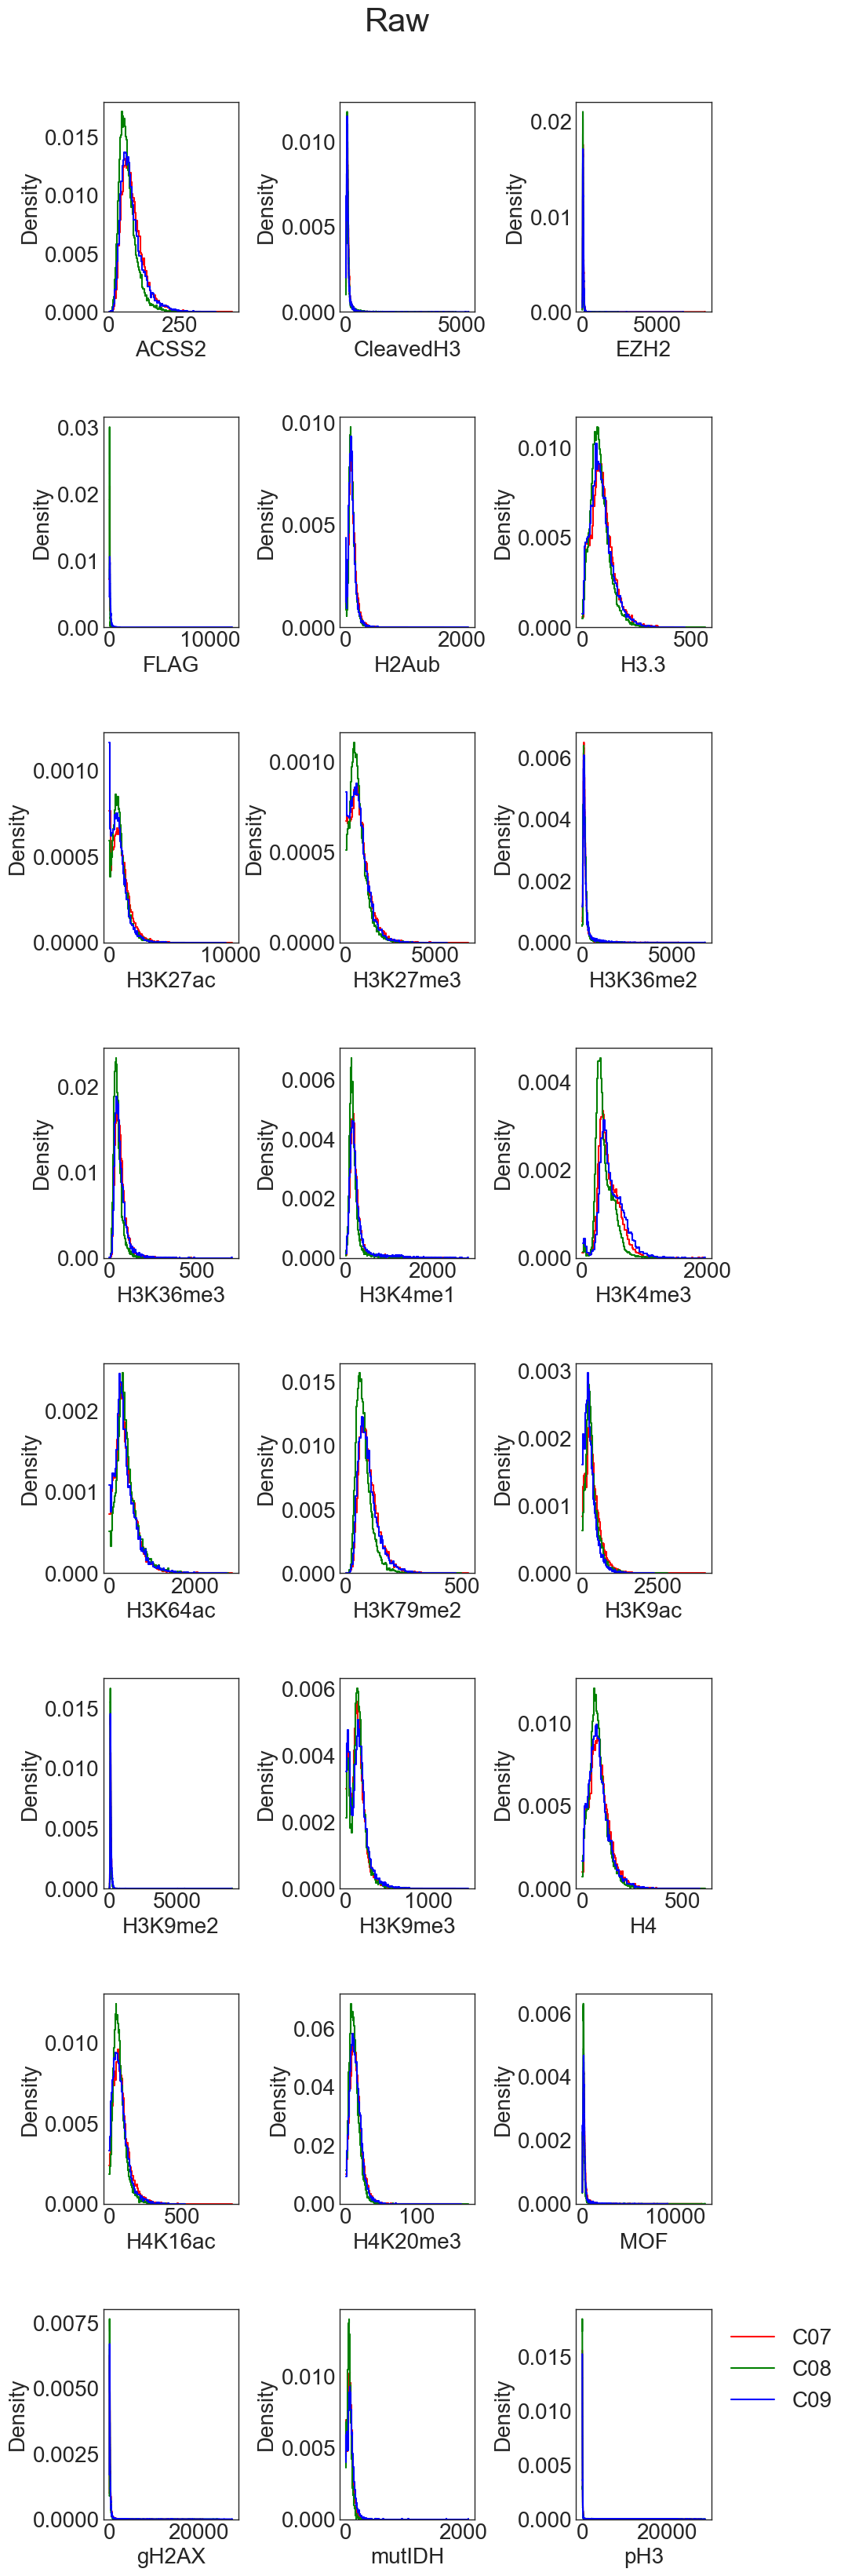

In [19]:
a=[]
fig, axs = plt.subplots(8, 3, figsize=(10, 40))
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        a.append(ax)
        
for i,N in enumerate(NamesAll):
    print(N)
    sns.histplot(C07[N],color='red',ax=a[i],label='C07',element='step',fill=False,stat='density')
    sns.histplot(C08[N],color='green',ax=a[i],label='C08',element='step',fill=False,stat='density')
    sns.histplot(C09[N],color='blue',ax=a[i],label='C09',element='step',fill=False,stat='density')

#    a[i].set_title(N)

plt.subplots_adjust(wspace=0.75, hspace=0.5)
a[23].legend(bbox_to_anchor=(1,1))    


fig.suptitle('Raw',y=0.91)
fig.savefig("Plots/Hist_Raw.png",dpi=200,bbox_inches='tight')

# Gate on H3.3/H4 too low, but also remove outliers 99.99% from all 

In [20]:
GateColumns=['H3.3','H4']#,'H3']#,'H3']
# #Ly7
# print("C01 Ly7")
# print(len(C01),len(C01))
# C01=C01[(C01[GateColumns]>5).all(axis=1)]
# print(len(C01),len(C01))
# C01=C01[(C01<np.quantile(C01,0.9999,axis=0)).all(axis=1)]
# print(len(C01),len(C01))

# #EZH2
# print("C03 EZH2")
# print(len(C03))
# C03=C03[(C03[GateColumns]>5).all(axis=1)]
# print(len(C03))
# C03=C03[(C03<np.quantile(C03,0.9999,axis=0)).all(axis=1)]
# print(len(C03))


def Gate(data,name):
    ddf=data.copy()
    print(name)
    print("Initial ",len(ddf))
    ddf=ddf[(ddf[GateColumns]>5).all(axis=1)]
    print("Core Gate ",len(ddf))
    ddf=ddf[(ddf<np.quantile(ddf,0.9999,axis=0)).all(axis=1)]
    print("Outlier Gate ",len(ddf))
    data=ddf.copy()
    del ddf
    return data



C07=Gate(C07,"FJ1")
C08=Gate(C08,"FJ1")
C09=Gate(C09,"FJ1")


FJ1
Initial  15603
Core Gate  15490
Outlier Gate  15453
FJ1
Initial  18729
Core Gate  18612
Outlier Gate  18572
FJ1
Initial  14262
Core Gate  14110
Outlier Gate  14068


In [21]:
scFac=5

C07=np.arcsinh(C07/scFac)
C08=np.arcsinh(C08/scFac)
C09=np.arcsinh(C09/scFac)


# Plots

ACSS2
CleavedH3
EZH2
FLAG
H2Aub
H3.3
H3K27ac
H3K27me3
H3K36me2
H3K36me3
H3K4me1
H3K4me3
H3K64ac
H3K79me2
H3K9ac
H3K9me2
H3K9me3
H4
H4K16ac
H4K20me3
MOF
gH2AX
mutIDH
pH3


Text(0.5, 0.91, 'ASinh')

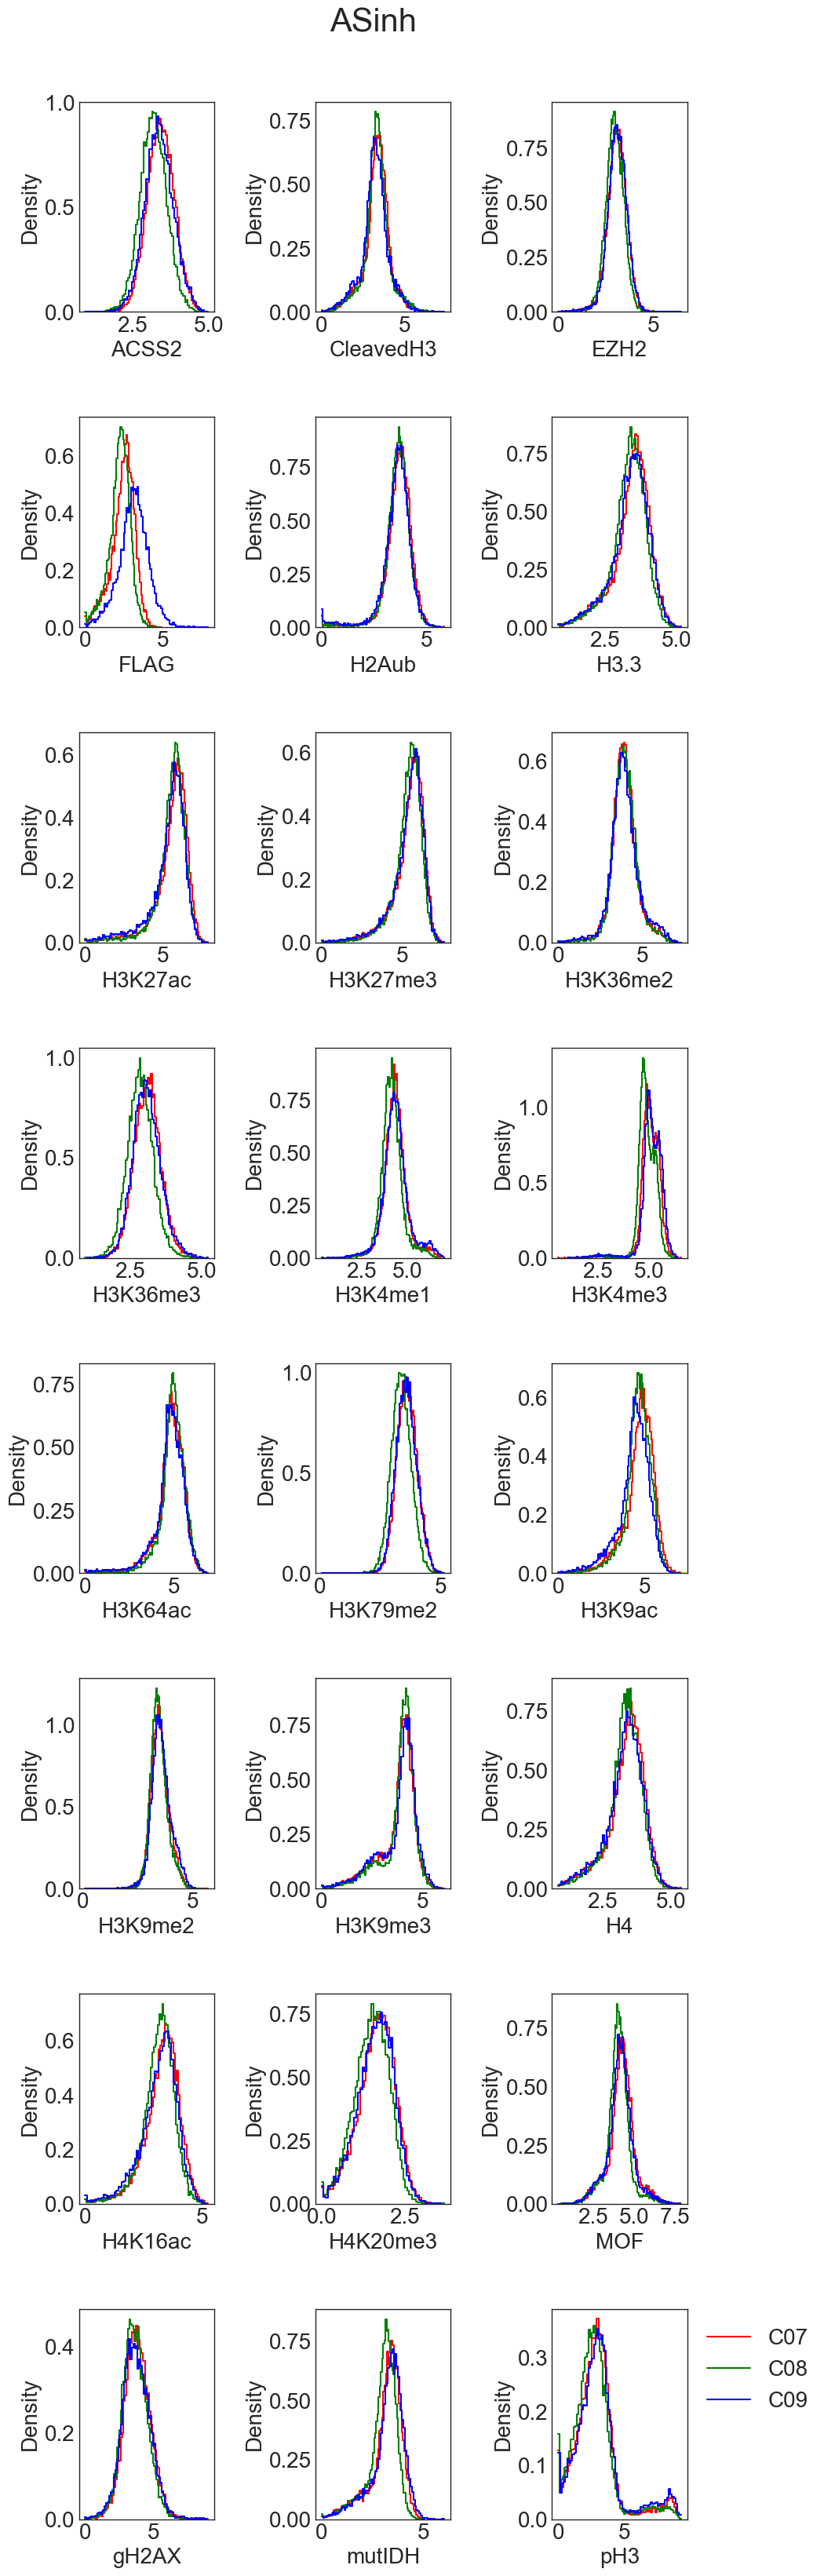

In [22]:
a=[]
fig, axs = plt.subplots(8, 3, figsize=(10, 40))
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        a.append(ax)
        
for i,N in enumerate(NamesAll):
    print(N)
    sns.histplot(C07[N],color='red',ax=a[i],label='C07',element='step',fill=False,stat='density')
    sns.histplot(C08[N],color='green',ax=a[i],label='C08',element='step',fill=False,stat='density')
    sns.histplot(C09[N],color='blue',ax=a[i],label='C09',element='step',fill=False,stat='density')

#    a[i].set_title(N)

plt.subplots_adjust(wspace=0.75, hspace=0.5)
a[23].legend(bbox_to_anchor=(1,1))    


fig.suptitle('ASinh',y=0.91)
#fig.savefig("Plots/Acetate_1_Raw.png",dpi=200,bbox_inches='tight')

fig.suptitle('ASinh',y=0.91)
#fig.savefig("Plots/Acetate_1_ASinh.png",dpi=200,bbox_inches='tight')

# Normalize using new method on all intercellular markers

In [23]:
def R(p,x,data,Q,M,M1,M2,M3):
    a=p['a']
    b=p['b']
    d=x.divide(a*M1+(1-a-b)*M2+b*M3,axis=0)
    return d.std()['H3.3']+d.std()['H4']+d.std()['H3']

def NormalizeNew(data):
    
    params = Parameters()
    params.add('a', value=0.1,min=0,max=1)
    params.add('b', value=0.1,min=0,max=1)
    ddf=data.copy()
    ddf2=data.copy()
    Q=ddf.mean()
    M=(ddf/Q)[['H3.3','H4','H3']].mean(axis=1)
    M1=(ddf/Q)['H3.3']
    M2=(ddf/Q)['H4']
    M3=(ddf/Q)['H3']

    out=minimize(R, params ,args=(ddf, ddf,Q,M,M1,M2,M3),method='cg')
    AA=out.params['a'].value
    BB=out.params['b'].value
    M=M1*AA+M2*(1-AA-BB)+M3*BB
    ddf=ddf.divide(M,axis=0).copy()
    data=ddf
    ddf2[EpiCols]=data[EpiCols]
    data=ddf2.copy()
    del ddf 
    del ddf2
    return data
    
def R2(p,x,data,Q,M,M1,M2):
    a=p['a']
    d=x.divide(a*M1+(1-a)*M2,axis=0)
    return (d.std()['H3.3'])**2+(d.std()['H4'])**2

def NormalizeNew2(data):
    
    params = Parameters()
    params.add('a', value=0.5,min=0.3,max=1)
    ddf=data.copy()
    ddf2=data.copy()
    Q=ddf.mean()
    M=(ddf/Q)[['H3.3','H4']].mean(axis=1)
    M1=(ddf/Q)['H3.3']
    M2=(ddf/Q)['H4']
 
    out=minimize(R2, params ,args=(ddf, ddf,Q,M,M1,M2),method='cg')
    AA=out.params['a'].value

    M=M1*AA+M2*(1-AA)
    ddf=ddf.divide(M,axis=0).copy()
    data=ddf.copy()
    print(data.shape,ddf2.shape)
    ddf2[EpiCols]=data[EpiCols]
    data=ddf2.copy()
    del ddf 
    del ddf2
    return data

In [24]:
EPC=EpiCols.copy()
EpiCols=NamesAll.copy()

C07=NormalizeNew2(C07)
C08=NormalizeNew2(C08)
C09=NormalizeNew2(C09)
EpiCols=EPC.copy()

(15453, 24) (15453, 24)
(18572, 24) (18572, 24)
(14068, 24) (14068, 24)


In [25]:
from tqdm import tqdm

Mean_Core=C07[['H3.3','H4']].mean(axis=1)
for N in tqdm(NamesAll):
    C07[N]=C07[N]/Mean_Core

Mean_Core=C08[['H3.3','H4']].mean(axis=1)
for N in tqdm(NamesAll):
    C08[N]=C08[N]/Mean_Core
    
    
Mean_Core=C09[['H3.3','H4']].mean(axis=1)
for N in tqdm(NamesAll):
    C09[N]=C09[N]/Mean_Core
    


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 2372.74it/s]


In [26]:
aaaa=pd.concat([
                C07.sample(n=10000,replace=True),
                C08.sample(n=10000,replace=True),
                C09.sample(n=10000,replace=True),

                ]).copy()

m=np.mean(aaaa,axis=0)
s=np.std(aaaa,axis=0)

C07=(C07-m)/s
C08=(C08-m)/s
C09=(C09-m)/s

params = {'axes.titlesize': 30,
          'legend.fontsize': 20,
          'figure.figsize': (6, 5),
          'axes.labelsize': 20,
          'axes.titlesize': 20,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'figure.titlesize': 30}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

/var/folders/c8/kfs4b_5d2yn86ycmhnycnfdh0000gn/T/ipykernel_54598/3059417899.py:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


a=[]
fig, axs = plt.subplots(8, 3, figsize=(10, 40))
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        a.append(ax)
        
for i,N in enumerate(NamesAll):
    print(N)
    sns.histplot(C07[N],color='red',ax=a[i],label='C07',element='step',fill=False,stat='density')
    sns.histplot(C08[N],color='green',ax=a[i],label='C08',element='step',fill=False,stat='density')
    sns.histplot(C09[N],color='blue',ax=a[i],label='C09',element='step',fill=False,stat='density')

#    a[i].set_title(N)

plt.subplots_adjust(wspace=0.75, hspace=0.5)
a[23].legend(bbox_to_anchor=(1,1))    


fig.suptitle('Normed-Scaled',y=0.91)
fig.savefig("Plots/Norm_Scaled.png",dpi=200,bbox_inches='tight')



In [27]:
C07.to_csv("Normed/C07_2HG.csv",index=False)
C09.to_csv("Normed/C09_2HG.csv",index=False)

In [34]:

C07['Line']='No Dox'
C08['Line']='2HG'
C09['Line']='Dox'


Colors={'No Dox':'dimgray', '2HG':'#573f8c','Dox':'blue'}

# UMAPs

## All Epigen

In [35]:
EPC=EpiCols.copy()
EPC.remove('H3.3')
EPC.remove('H4')

In [36]:
CAll=pd.concat([
    C07.sample(10000,replace=False),
    C08.sample(10000,replace=False),
    C09.sample(10000,replace=False),
]).copy()

X_2d=draw_umap(CAll[EPC],cc=CAll['H3K27me3'],min_dist=0.001,n_neighbors=60,rstate=42)
plt.show()



plt.figure(figsize=(5,5))
for L in CAll.Line.unique():
    m=CAll.Line==L
    plt.scatter(X_2d[m,0],X_2d[m,1],s=1,color=Colors[L],label=L)
    
plt.legend(bbox_to_anchor=(1,1),markerscale=10)
plt.xlabel('UMAP 0');
plt.xlabel('UMAP 1');
plt.savefig('Plots/2HG_Epigen_IDX.png',dpi=200,bbox_inches='tight')

for NN in NamesAll:
    Var=NN
    TSNEVar=NN
    cc=CAll[NN]#[mask]
    plt.figure(figsize=(6, 5))

    plt.scatter(X_2d[:,0],X_2d[:,1],s=2,
                c=cc, cmap=plt.cm.seismic)

    plt.colorbar()

    plt.clim(cc.quantile(0.01),cc.quantile(0.99))
    plt.title("(All Epigen) "+TSNEVar)
    plt.xlabel('UMAP 0');
    plt.xlabel('UMAP 1');
    plt.savefig('Plots/2HG_Epigen_'+NN+'_CyTOF1.png',dpi=200,bbox_inches='tight')

    plt.show()

# Pride

/var/folders/c8/kfs4b_5d2yn86ycmhnycnfdh0000gn/T/ipykernel_31925/1024288325.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


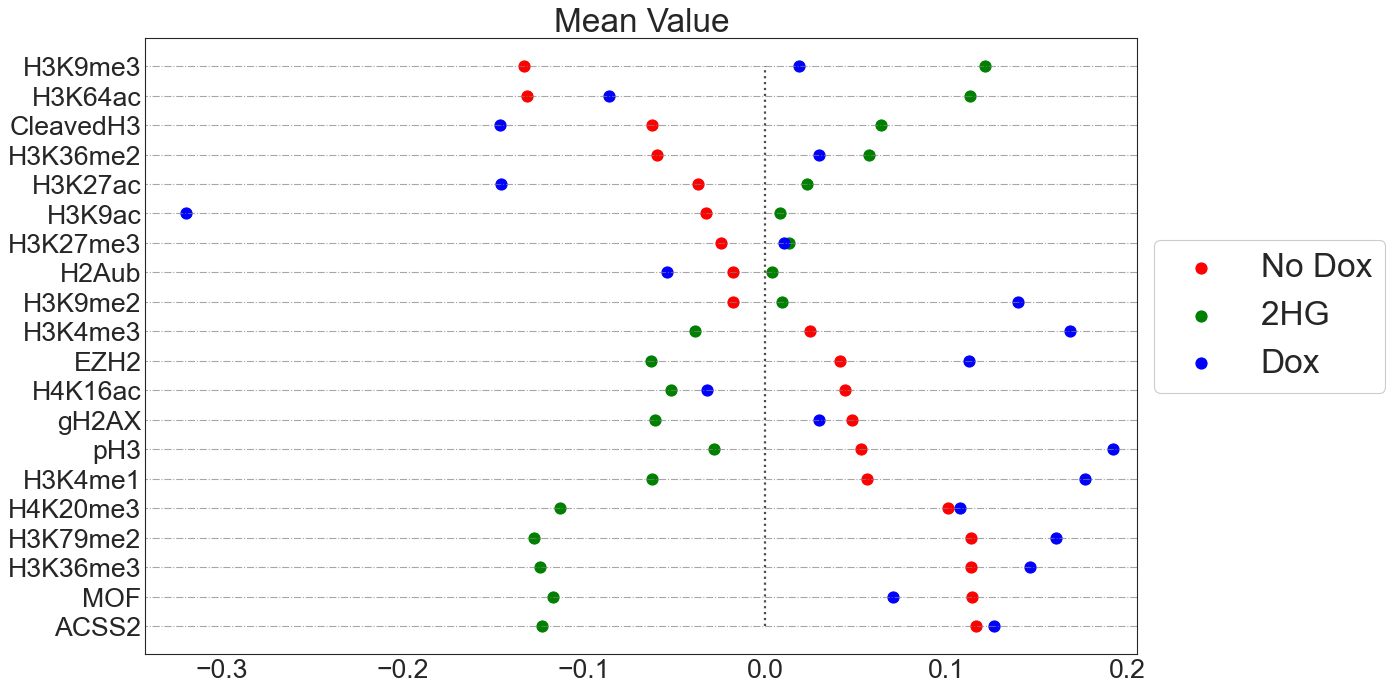

In [37]:
Names=NamesAll.copy()
Names.remove('H3.3')
Names.remove('H4')
Names.remove('FLAG')
Names.remove('mutIDH')
sns.set_style({'legend.frameon':True})

dd0=np.mean(C07[Names],axis=0).sort_values(ascending=False)
dd1=np.mean(C08[Names],axis=0)
dd2=np.mean(C09[Names],axis=0)




    
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
ax.hlines(y=dd0.index, xmin=-5, xmax=5, color='gray', alpha=0.7, 
          linewidth=1, linestyles='dashdot')

ax.scatter(y=dd0.index, x=dd0, s=100, c='red', alpha=1,
           label='No Dox',)
ax.scatter(y=dd1.index, x=dd1, s=100, c='green', alpha=1,
           label='2HG',)

ax.scatter(y=dd2.index, x=dd2, s=100, c='blue', alpha=1,
           label='Dox',)


ax.vlines(x=0, ymin=0, ymax=len(dd0)-1, color='black', alpha=0.7, linewidth=2, linestyles='dotted')
plt.legend(fontsize=30,
           facecolor='White', framealpha=1,frameon=True,
           bbox_to_anchor=(1.0, .50, 0.3, 0.2), loc='upper left')

ax.set_title('Mean Value', fontdict={'size':30})

labels = dd0.index.to_list()
#labels[8]="H3-K27M"
ax.set_yticklabels(labels)
mn=CAll.groupby('Line')[Names].mean().min().min()*1.1
mx=CAll.groupby('Line')[Names].mean().max().max()*1.1
ax.set_xlim([mn,mx])
plt.setp(ax.get_xticklabels(), fontsize=24)
plt.setp(ax.get_yticklabels(), fontsize=24)

#plt.savefig('Plots/Pride_2HG.png',dpi=200,bbox_inches='tight')

plt.show()

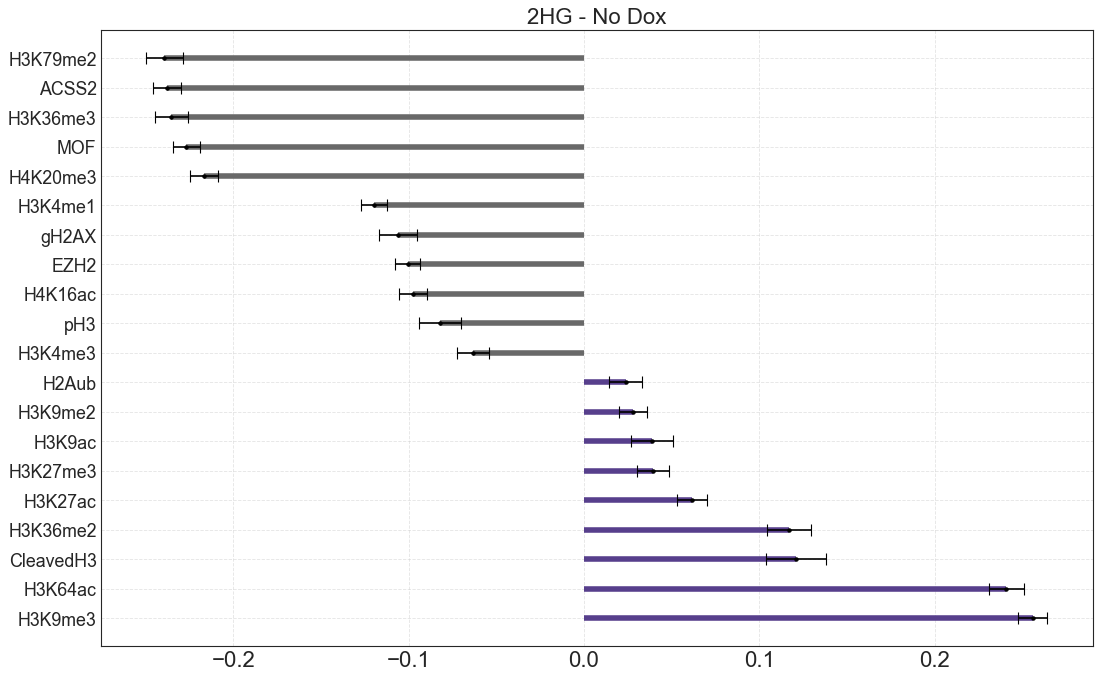

In [39]:
MeanDistReSamp(C07,C08,Names,title='2HG - No Dox',clr=[Colors['No Dox'],Colors['2HG']]);

plt.savefig('Plots/2HG_Mean1.pdf',dpi=200,bbox_inches='tight')



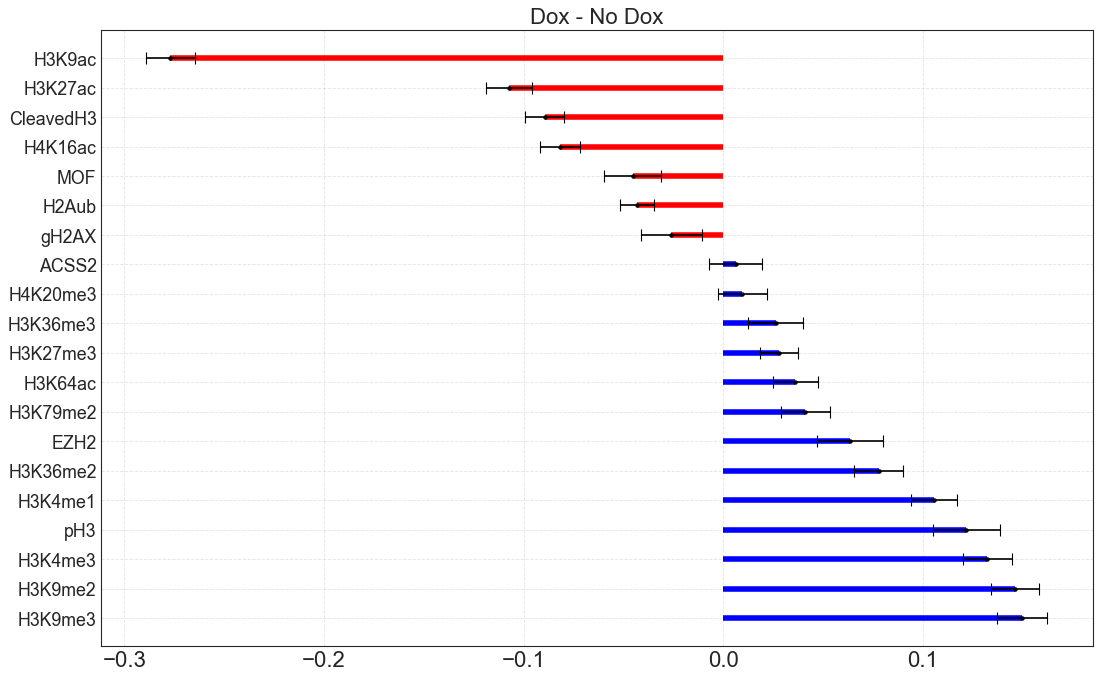

In [58]:
MeanDistReSamp(C07,C09,Names,title='Dox - No Dox',clr=['red','blue']);
plt.savefig('Plots/2HG_Mean2.png',dpi=200,bbox_inches='tight')

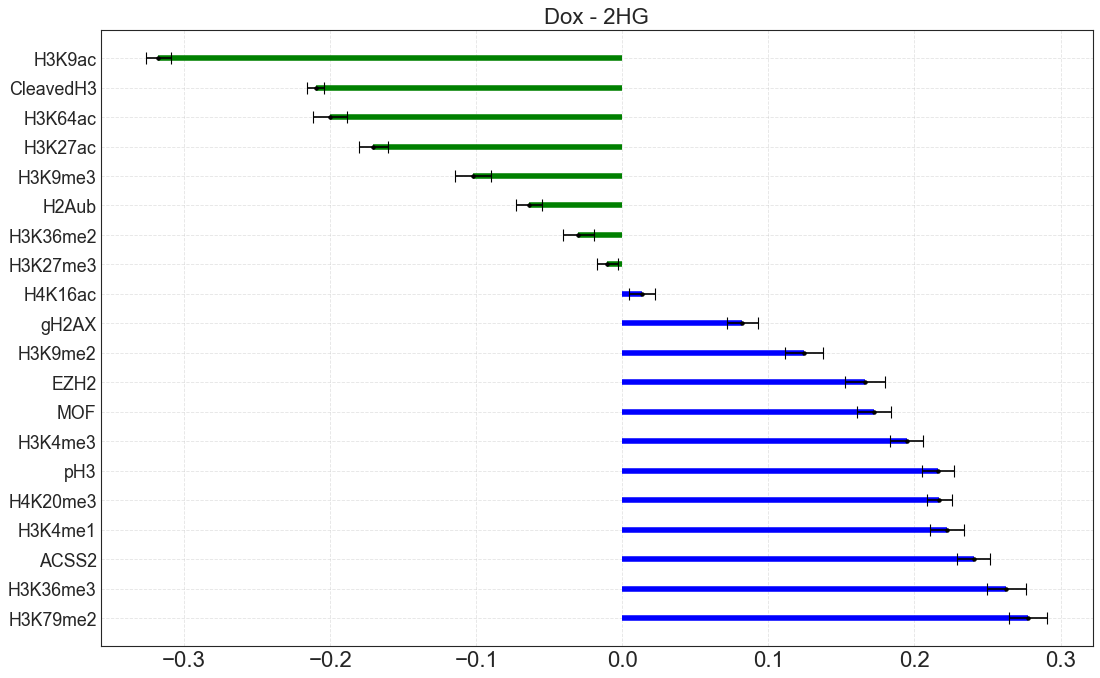

In [59]:
MeanDistReSamp(C08,C09,Names,title='Dox - 2HG',clr=['green','blue']);
plt.savefig('Plots/2HG_Mean3.png',dpi=200,bbox_inches='tight')

<Figure size 500x600 with 0 Axes>

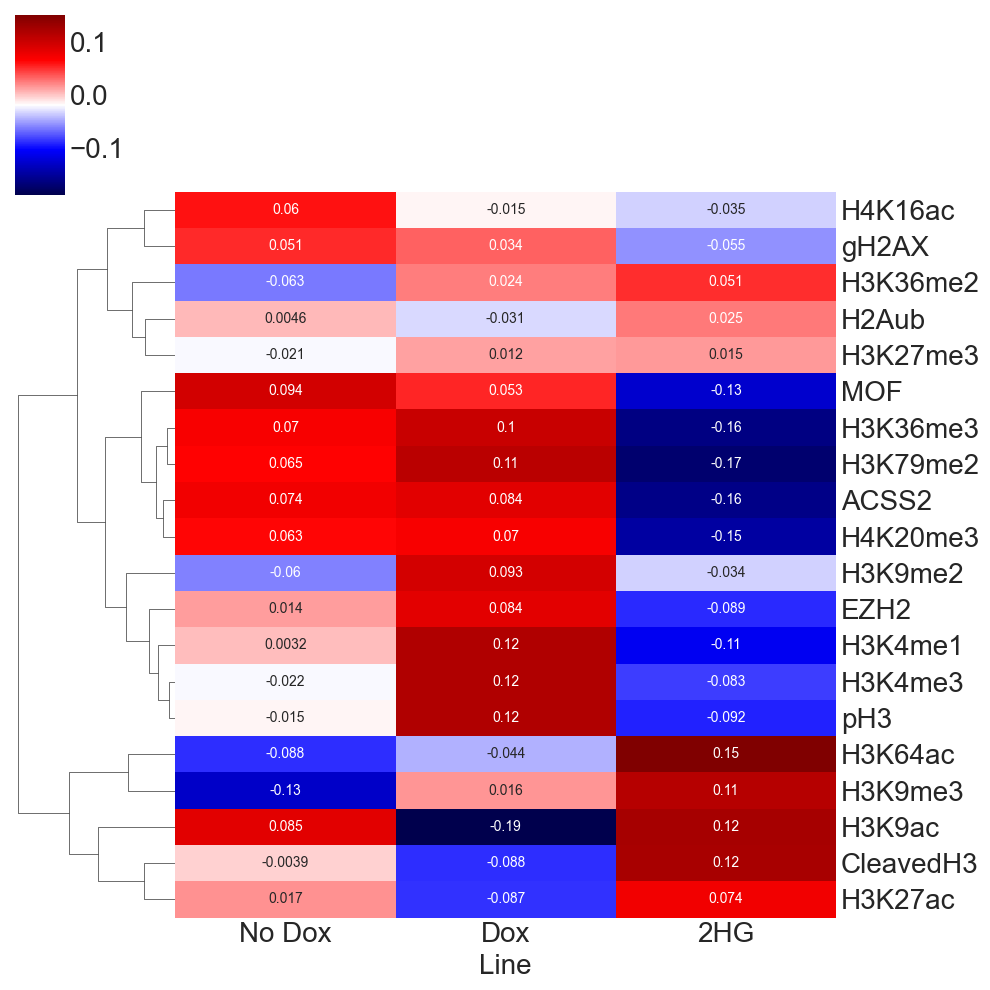

In [61]:
CAll=pd.concat([C07,C08,C09]).copy()
plt.figure(figsize=(5,6))

Mat=CAll.groupby('Line')[Names].mean()
Mat=Mat.loc[['No Dox','Dox','2HG']]
sns.clustermap(Mat.T,annot=True,cmap=plt.cm.seismic,yticklabels=True,col_cluster=False)
plt.savefig('Plots/2HG_ClustMap.png',dpi=200,bbox_inches='tight')

<Figure size 500x600 with 0 Axes>

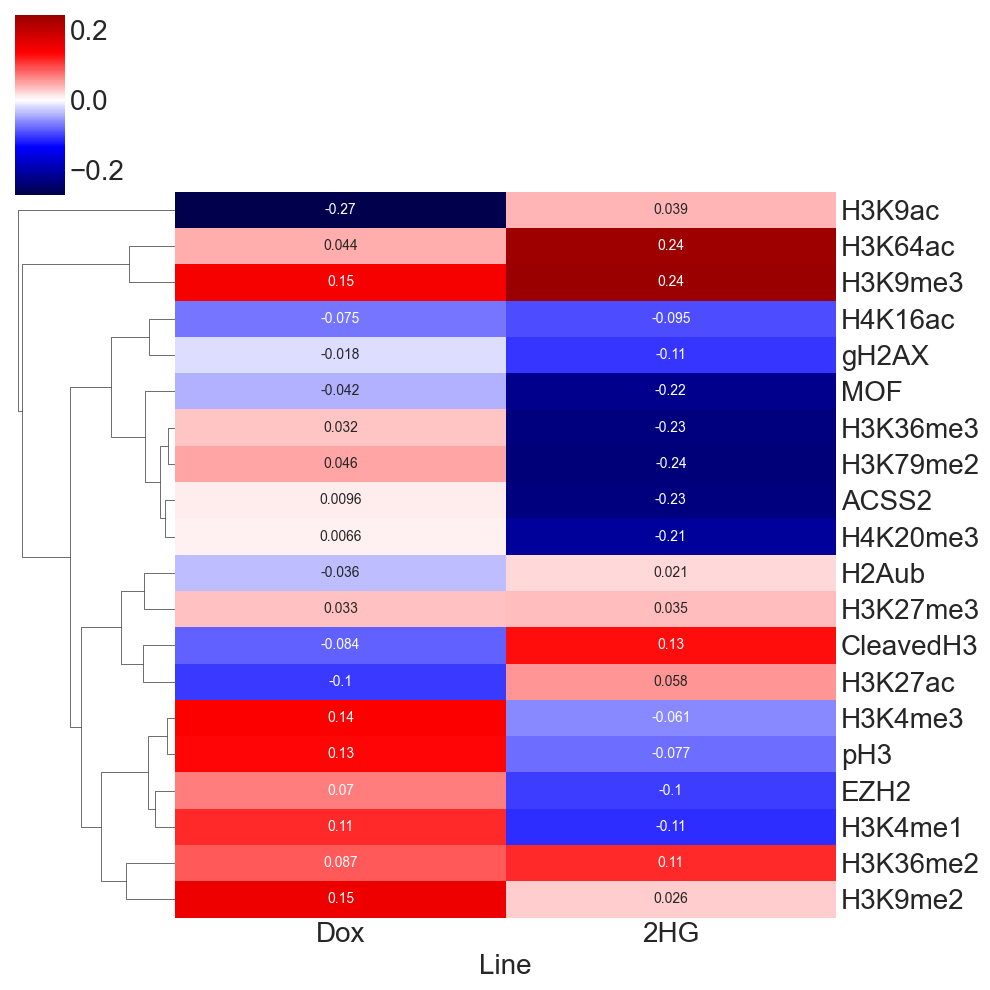

In [62]:
CAll=pd.concat([C07,C08,C09]).copy()
plt.figure(figsize=(5,6))

Mat=CAll.groupby('Line')[Names].mean()
Mat=Mat.loc[['No Dox','Dox','2HG']]
sns.clustermap((Mat-Mat.iloc[0]).iloc[1:3].T,annot=True,cmap=plt.cm.seismic,yticklabels=True,col_cluster=False,center=0)
plt.savefig('Plots/2HG_ClustMap2_NormedtoNoDox.png',dpi=200,bbox_inches='tight')

# MeanDist

In [ ]:
Diffs=C06.mean(axis=0)-C05.mean(axis=0)

In [ ]:
Diffs

In [ ]:
import scipy.stats as stats
import statsmodels.stats.multitest as mt

In [ ]:
p=[]
ps=[]
for N in NamesAll:
    pp=stats.ttest_ind(C06[N],C05[N],equal_var=False,)[1]
    pS=stats.ttest_ind(C06[N],C05[N],equal_var=False,)[0]
    print(N,pp)
    p.append(pp)
    ps.append(pS)
p=np.asarray(p)

In [ ]:
ps

In [ ]:
qvals=mt.multipletests(p,)[1]
qS=mt.multipletests(p,)[0]

In [ ]:
VP=pd.DataFrame(Diffs,columns=['Diff'])

In [ ]:
VP['p']=qvals

In [ ]:
VP

In [ ]:
from bioinfokit import analys, visuz

In [ ]:
visuz.GeneExpression.volcano(df=VP, lfc='Diff', pv='p',lfc_thr=[-.01,.01])
plt.show()

In [ ]:
plt.scatter(VP['Diff'][qS],-np.log10(VP['p'])[qS],c='r')
plt.scatter(VP['Diff'][~qS],-np.log10(VP['p'])[~qS],c='gray')

In [ ]:
NMS.remove('Ki67')
NMS.remove('mutIDH')
NMS.remove('FLAG')
NMS.remove('pH3')

In [ ]:
D56=MeanDistReSamp(C05,C06,NMS,title='C06 - C05',nsamp=50);











In [ ]:
D89=MeanDistReSamp(C08,C09,NMS,title='C09 - C08',nsamp=50);

In [ ]:
D89.columns=['M2','S2']

In [ ]:
DComb=pd.concat([D56,D89],axis=1)
DComb['MM']=DComb['M2']-DComb['M']

In [ ]:
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
diffs=DComb.sort_values(by='MM',ascending=False).copy()
#diffs=D56.copy()
clr=['red','blue']
colors = [clr[0] if x < 0 else clr[1] for x in diffs.M]
#plt.hlines(y=diffs.index, xmin=0, xmax=diffs.M, color=colors, alpha=1, linewidth=5)
plt.errorbar(y=diffs.index,x=diffs.M,xerr=diffs.S,capsize=5,fmt='r.',label='C06-C05')
# Decorations
plt.gca().set(ylabel='', xlabel='')
plt.xticks(fontsize=20 ) 
plt.yticks(fontsize=16 ) 

#diffs2=D89.sort_values(by='M2',ascending=False).copy()
clr=['pink','cyan']
colors = [clr[0] if x < 0 else clr[1] for x in diffs.M2]
#plt.hlines(y=diffs.index, xmin=0, xmax=diffs.M2, color=colors, alpha=1, linewidth=5)
plt.errorbar(y=diffs.index,x=diffs.M2,xerr=diffs.S2,capsize=5,fmt='b.',label='C09-C08')

plt.plot([0,0],[-1,20],'k')
plt.ylim([-1,14])
plt.title('Mean Diffs', fontdict={'size':20})
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.xlabel('Mean Diff')
plt.grid(linestyle='--', alpha=0.5)         
plt.savefig('Plots/Acetate_Diffs_1.png',dpi=200,bbox_inches='tight')


In [ ]:
diffs.index

In [ ]:
NMS=[
 'MOF',
 'H3K9ac',
 'H3K64ac',
 'H3K27ac',
 'ACSS2',
 'H4K16ac',
]



In [ ]:
DComb.loc[NMS]

In [ ]:
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
diffs=DComb.loc[NMS].sort_values(by='MM',ascending=False).copy()
#diffs=D56.copy()
clr=['red','blue']
colors = [clr[0] if x < 0 else clr[1] for x in diffs.M]
#plt.hlines(y=diffs.index, xmin=0, xmax=diffs.M, color=colors, alpha=1, linewidth=5)
plt.errorbar(y=diffs.index,x=diffs.M,xerr=diffs.S,capsize=5,fmt='r.',label='C06-C05')
# Decorations
plt.gca().set(ylabel='', xlabel='')
plt.xticks(fontsize=20 ) 
plt.yticks(fontsize=16 ) 

#diffs2=D89.sort_values(by='M2',ascending=False).copy()
clr=['pink','cyan']
colors = [clr[0] if x < 0 else clr[1] for x in diffs.M2]
#plt.hlines(y=diffs.index, xmin=0, xmax=diffs.M2, color=colors, alpha=1, linewidth=5)
plt.errorbar(y=diffs.index,x=diffs.M2,xerr=diffs.S2,capsize=5,fmt='b.',label='C09-C08')

plt.plot([0,0],[-1,6],'k')
plt.ylim([-1,6])
plt.title('Mean Diffs', fontdict={'size':20})
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.xlabel('Mean Diff')
plt.grid(linestyle='--', alpha=0.5)         
plt.savefig('Plots/Acetate_Diffs_2.png',dpi=200,bbox_inches='tight')


In [ ]:
diffs['SS']=np.sqrt(diffs['S']**2+diffs['S2']**2)
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
plt.hlines(y=diffs.index, xmin=0, xmax=diffs['MM'], color='r', alpha=1, linewidth=5)
plt.errorbar(y=diffs.index, x=diffs['MM'],xerr=diffs['SS'], fmt='k.', alpha=1, linewidth=1,capsize=5)
# Decorations
plt.gca().set(ylabel='', xlabel='');
plt.xticks(fontsize=20 ); 
plt.yticks(fontsize=16 ); 
plt.grid(linestyle='--', alpha=0.5)         
plt.plot([0,0],[-1,5.5],'k--')
plt.ylim([-0.5,5.5])
plt.xlabel('Difference of Differences')
plt.savefig('Plots/Acetate_Diffs_Diff.png',dpi=200,bbox_inches='tight')


In [ ]:
MeanDistReSamp(C05,C06,NMS,title='NoDox Acetate - No Acetate',clr=['red','orange'],nsamp=50);
plt.savefig('Plots/Mean_3.png',dpi=200,bbox_inches='tight')


In [ ]:
MeanDistReSamp(C08,C09,NMS,title='Dox Acetate - No Acetate',clr=['green','blue'],nsamp=50);
plt.savefig('Plots/Mean_4.png',dpi=200,bbox_inches='tight')


In [ ]:
MeanDistReSamp(C05,C08,NMS,title='Dox Acetate - No Acetate',clr=['red','green'],nsamp=50);

In [ ]:
diffs['SS']=np.sqrt(diffs['S']**2+diffs['S2']**2)
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
plt.hlines(y=np.arange(0,len(diffs.index))+0.1, xmin=0, xmax=diffs['M'], color='r', alpha=1, linewidth=5)
plt.errorbar(y=np.arange(0,len(diffs.index))+0.1, x=diffs['M'],xerr=diffs['S'], fmt='k.', alpha=1, linewidth=1,capsize=5)

plt.hlines(y=range(len(diffs.index)), xmin=0, xmax=diffs['M2'], color='b', alpha=1, linewidth=5)
plt.errorbar(y=diffs.index, x=diffs['M2'],xerr=diffs['S2'], fmt='k.', alpha=1, linewidth=1,capsize=5)

# Decorations
plt.gca().set(ylabel='', xlabel='');
plt.xticks(fontsize=20 ); 
plt.yticks(fontsize=16 ); 
plt.grid(linestyle='--', alpha=0.5)         
plt.plot([0,0],[-1,5.5],'k--')
plt.ylim([-0.5,5.5])
plt.xlabel('Difference of Differences')
plt.savefig('Plots/Acetate_Diffs_3.png',dpi=200,bbox_inches='tight')


In [ ]:
NMS
Colors={}
Colors['H3K9ac']='red'
Colors['H3K64ac']='orange'
Colors['H3K27ac']='green'
Colors['H4K16ac']='blue'

In [ ]:
plt.figure(figsize=(2,6))
for N in list(Colors.keys()):
    plt.scatter(x=0,y=diffs.loc[N,'M'],color=Colors[N],label=N)
    plt.errorbar(x=0,y=diffs.loc[N,'M'],yerr=diffs.loc[N,'S'],capsize=5,color=Colors[N])
    
    plt.scatter(x=.1,y=diffs.loc[N,'M2'],color=Colors[N])
    plt.errorbar(x=.1,y=diffs.loc[N,'M2'],yerr=diffs.loc[N,'S2'],capsize=5,color=Colors[N])
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.xlim(-0.1,0.2)
#    plt.plot([-.1,.2],[0,0],'k--',lw=.1)
    plt.savefig('Plots/Acetate_Diffs_4.png',dpi=200,bbox_inches='tight')
